In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision

# 生成训练数据

In [3]:
import lib.data.gen_data as gd
import lib.data.dataset as ds

# 生成文字图片
gd.gen_data(100)

# 根据生成文字图片，保存到lmdb
ds.main_create_data()

# 加载训练数据

In [5]:
import lib.data.lmdb_dataset as lds
import torch
train_path = '/home/hecong/temp/data/ocr/lmdb'
batchSize = 2
sampler = None
workers = 1
imgH = 32
imgW = 256

train_dataset = lds.lmdbDataset(root=train_path)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batchSize,
    shuffle=False,
    sampler=sampler,
    num_workers=int(workers),
    collate_fn=lds.alignCollate(imgH=imgH, imgW=imgW, keep_ratio=True))

('bcdefghijk', 'lmn1234567', ']ABCDEFGHI', '234567890.', 'klmn123456')


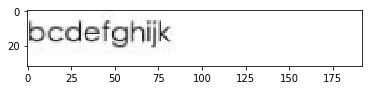

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
_,(image,label) = next(enumerate(train_loader))
image_0 = image[0][0]
image_0 = image_0.numpy()
print(label)
plt.imshow(image_0,'gray')
plt.show()


# 模型

In [3]:
import torch.nn as nn
import torch.nn.parallel

# custom weights initialization called on crnn
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def data_parallel(model, input, ngpu):
    if ngpu > 1 and isinstance(input.data, torch.cuda.FloatTensor):
        output = nn.parallel.data_parallel(model, input, range(ngpu))
    else:
        output = model(input)
    return output
    
class BidirectionalLSTM(nn.Module):
    def __init__(self, nIn, nHidden, nOut, ngpu):
        super(BidirectionalLSTM, self).__init__()
        self.ngpu = ngpu
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = data_parallel(self.rnn, input,
                                           self.ngpu)  # [T, b, h * 2]
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = data_parallel(self.embedding, 
                               t_rec,self.ngpu)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

class CRNN(nn.Module):
    def __init__(self, imgH, nc, nclass, nh, ngpu, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        self.ngpu = ngpu
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))
                                                                    
        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        # pool = nn.MaxPool2d(kernel_size=2, stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
        # 注意MaxPool2d 当stride = (2,1),表示只会根据H轴方向进行Pool，因为W方向是1。
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16

        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh, ngpu),
            BidirectionalLSTM(nh, nh, nclass, ngpu))

    def forward(self, input):
        # conv features
#         print('input size --> {}'.format(input.size()))
        conv = data_parallel(self.cnn, input, self.ngpu)
        b, c, h, w = conv.size()
#         print('conv out size --> {}'.format(conv.size()))
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        
        # rnn features
        output = data_parallel(self.rnn, conv, self.ngpu)
        return output


# 训练

In [8]:
import lib.data.char as c
from warpctc_pytorch import CTCLoss
import lib.utils as utils
import torch.optim as optim
import os
import importlib
importlib.reload(utils)


ngpu = 0
# size of the lstm hidden state
nh = 256
nclass = len(c.alphabet) + 1
# input channel ， 因为训练图片是转成灰度图，所以该值为1
nc = 1
lr = 0.001
beta1=0.5
EPOCH = 1000




# 字符转换编码
converter = utils.strLabelConverter(c.alphabet)
# 损失函数
criterion = CTCLoss()

crnn = CRNN(imgH, nc, nclass, nh, ngpu)
crnn.apply(weights_init)
if os.path.exists('/home/hecong/temp/data/ocr/simple_ocr.pkl'):
    crnn.load_state_dict(torch.load('/home/hecong/temp/data/ocr/simple_ocr.pkl'))

image = torch.FloatTensor(batchSize, 3, imgH, imgH)
text = torch.IntTensor(batchSize * 5)
length = torch.IntTensor(batchSize)

optimizer = optim.Adam(
    crnn.parameters(), lr=lr, betas=(beta1, 0.999))

for epoch in range(EPOCH):
    for step,(t_image,t_label) in enumerate(train_loader):
        batch_size = t_image.size(0)
        utils.loadData(image, t_image)
        t, l = converter.encode(t_label)
        utils.loadData(text, t)
        utils.loadData(length, l)

        preds = crnn(image)
        preds_size = Variable(torch.IntTensor([preds.size(0)] * batch_size))
        optimizer.zero_grad()
        cost = criterion(preds, text, preds_size, length) / batch_size
        cost.backward()
        optimizer.step()
        
        if step % 10 == 0:
            print('{}:{} loss --> {}'.format(epoch, step, cost))
            torch.save(crnn.state_dict(), '/home/hecong/temp/data/ocr/simple_ocr.pkl')

0:0 loss --> tensor([0.3532], grad_fn=<DivBackward0>)
0:10 loss --> tensor([0.3041], grad_fn=<DivBackward0>)
0:20 loss --> tensor([0.4410], grad_fn=<DivBackward0>)
1:0 loss --> tensor([0.3675], grad_fn=<DivBackward0>)
1:10 loss --> tensor([0.2539], grad_fn=<DivBackward0>)
1:20 loss --> tensor([0.2896], grad_fn=<DivBackward0>)
2:0 loss --> tensor([0.2045], grad_fn=<DivBackward0>)
2:10 loss --> tensor([0.2958], grad_fn=<DivBackward0>)
2:20 loss --> tensor([0.2850], grad_fn=<DivBackward0>)
3:0 loss --> tensor([0.1428], grad_fn=<DivBackward0>)
3:10 loss --> tensor([0.1936], grad_fn=<DivBackward0>)
3:20 loss --> tensor([0.2244], grad_fn=<DivBackward0>)
4:0 loss --> tensor([0.1102], grad_fn=<DivBackward0>)
4:10 loss --> tensor([0.1454], grad_fn=<DivBackward0>)
4:20 loss --> tensor([0.1879], grad_fn=<DivBackward0>)
5:0 loss --> tensor([0.0654], grad_fn=<DivBackward0>)
5:10 loss --> tensor([0.1203], grad_fn=<DivBackward0>)
5:20 loss --> tensor([0.1348], grad_fn=<DivBackward0>)
6:0 loss --> ten

49:10 loss --> tensor([0.0003], grad_fn=<DivBackward0>)
49:20 loss --> tensor([0.0004], grad_fn=<DivBackward0>)
50:0 loss --> tensor([0.0005], grad_fn=<DivBackward0>)
50:10 loss --> tensor([0.0003], grad_fn=<DivBackward0>)
50:20 loss --> tensor([0.0004], grad_fn=<DivBackward0>)
51:0 loss --> tensor([0.0005], grad_fn=<DivBackward0>)
51:10 loss --> tensor([0.0003], grad_fn=<DivBackward0>)
51:20 loss --> tensor([0.0004], grad_fn=<DivBackward0>)
52:0 loss --> tensor([0.0005], grad_fn=<DivBackward0>)
52:10 loss --> tensor([0.0003], grad_fn=<DivBackward0>)
52:20 loss --> tensor([0.0004], grad_fn=<DivBackward0>)
53:0 loss --> tensor([0.0004], grad_fn=<DivBackward0>)
53:10 loss --> tensor([0.0003], grad_fn=<DivBackward0>)
53:20 loss --> tensor([0.0004], grad_fn=<DivBackward0>)
54:0 loss --> tensor([0.0004], grad_fn=<DivBackward0>)
54:10 loss --> tensor([0.0003], grad_fn=<DivBackward0>)
54:20 loss --> tensor([0.0004], grad_fn=<DivBackward0>)
55:0 loss --> tensor([0.0004], grad_fn=<DivBackward0>

Process Process-153:
Traceback (most recent call last):
  File "/home/hecong/tools/python3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/hecong/tools/python3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hecong/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/hecong/tools/python3/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/home/hecong/tools/python3/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/hecong/tools/python3/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/hecong/tools/python3/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select

KeyboardInterrupt: 

In [15]:
# preds_size = torch.IntTensor([49])
# length = torch.IntTensor([49])
print(preds.size())
print(text.size())
print(text)
print(preds_size)
print(length)

criterion(preds, text, preds_size, length)

# prob size --> torch.Size([2, 1, 5])
# labels size --> torch.Size([2])
# prob sizes -->tensor([2], dtype=torch.int32)
# label sizes -->tensor([2], dtype=torch.int32)

torch.Size([49, 2, 42])
torch.Size([20])
tensor([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22], dtype=torch.int32)
tensor([49, 49], dtype=torch.int32)
tensor([2], dtype=torch.int32)


tensor([171.5280], grad_fn=<_CTCBackward>)

In [7]:
torch.save(crnn.state_dict(), '/home/hecong/temp/data/ocr/simple_ocr.pkl')